## Imports

In [1]:
%env LD_LIBRARY_PATH=/home/zach/anaconda3/envs/research/lib

env: LD_LIBRARY_PATH=/home/zach/anaconda3/envs/research/lib


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
import re
import codecs
from tqdm import tqdm

## Data Import and Cleaning

In [3]:
train = pd.read_csv('data/hateval2019_en_train.csv')
test = pd.read_csv('data/hateval2019_en_test.csv')
val = pd.read_csv('data/hateval2019_en_dev.csv')

train = train.drop(['TR','AG'],1)
test = test.drop(['TR','AG'],1)
val = val.drop(['TR','AG'],1)

/tmp/ipykernel_25524/675437588.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train = train.drop(['TR','AG'],1)
/tmp/ipykernel_25524/675437588.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test = test.drop(['TR','AG'],1)
/tmp/ipykernel_25524/675437588.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  val = val.drop(['TR','AG'],1)


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-05-23 18:01:59.223188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 18:01:59.310138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 18:01:59.310524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
train.head()

,id,text,HS
0,201,"Hurray, saving us $$$ in so many ways @potus @...",1
1,202,Why would young fighting age men be the vast m...,1
2,203,@KamalaHarris Illegals Dump their Kids at the ...,1
3,204,NY Times: 'Nearly All White' States Pose 'an A...,0
4,205,Orban in Brussels: European leaders are ignori...,0


In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import L1,L2, l1_l2
import io

In [7]:
def normalize_tweet(text):
    """
    Removes hashtags, @s, links, and punctuation
    :param text:Text to be cleaned
    :return: text with mentions, hashtages, and urls removes
    """
    processed_text = text.lower()
    processed_text = re.sub(r"(?:\@|http?\://|https?\://|www|t\.)\S+", "", processed_text)
    processed_text = re.sub(r"(?:\.|,|\?|-)", " ", processed_text)
    processed_text = re.sub(r"(?:\@|http?\://|https?\://|www|\.com)", "", processed_text)
    processed_text = re.sub(r'[^\w\s]', '', processed_text)
    processed_text = " ".join(processed_text.split())
    return processed_text

def x_y_split(data):
    """splits and X and y from dataframe

    Args:
        data:dataframe to split from

    Returns:
        tuple:X data, y data
    """
    X = data['text']
    X = X.apply(normalize_tweet)
    y = data['HS']
    return X, y

## Split sequences into train, validation, and test sets

In [8]:
#Split x and ys
x_train, y_train = x_y_split(train)
print(x_train)
#x_train.to_csv('data/x_train.csv')
#y_train.to_csv('data/y_train.csv')

0       hurray saving us in so many ways lockthemup bu...
1       why would young fighting age men be the vast m...
2       illegals dump their kids at the border like ro...
3       ny times nearly all white states pose an array...
4       orban in brussels european leaders are ignorin...
                              ...                        
8995                  i am proud to be a hysterical woman
8996    hollywood is complicit in the rape and sexual ...
8997    what a fucking cunt i hate seeing kids getting...
8998                                hysterical woman like
8999    nearly every woman i know has metoo in their f...
Name: text, Length: 9000, dtype: object


In [9]:
#Split x and ys
x_test, y_test = x_y_split(test)
print(x_test)
#x_test.to_csv('data/x_test.csv')
#y_test.to_csv('data/y_test.csv')

0       oh i could have gone on about taxes since the ...
1       several of the wild fires in california and co...
2       my question is how do you resettle a refugee a...
3       europe youve got a problem we must hurry and b...
4       this is outrageous stopillegalimmigration meri...
                              ...                        
2995    you can never take a l off a real bitch im hot...
2996    likes to call me a cunt a bitch but i tell him...
2997    1 never said you were taught 2 you called me b...
2998    if i see and know you a hoe why would i hit yo...
2999     you be chasing them hoes fuck what a bitch think
Name: text, Length: 3000, dtype: object


In [10]:
#Split x and ys
x_val, y_val = x_y_split(val)
print(x_val)
#x_val.to_csv('data/x_val.csv')
#y_val.to_csv('data/y_val.csv')

0      i swear im getting to places just in the nick ...
1      im an immigrant and trump is right on immigrat...
2      illegalimmigrants illegalaliens electoralsyste...
3      we have our own invasion issues with mexicans ...
4      worker charged with sexually molesting eight c...
                             ...                        
995                     you unfollowed me fuck you pussy
996    stfu bitch and you go make some satanic music ...
997    honey as a fellow white chick let me tell you ...
998    i hate bitches who talk about niggaz with kids...
999    you won the life time recipient for hysterical...
Name: text, Length: 1000, dtype: object


## Tokenizer

In [11]:
max_features = 5000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(x_train)


def tokenize_and_pad(x_data, tokenizer=tokenizer, length=57):
    """
    Tokenizes and pads input
    :param x_data: X column of data
    :param tokenizer: fitted tokenizer
    :param length: length to pad
    :return: tokenized and padded x_data
    """
    x_data = tokenizer.texts_to_sequences(x_data)
    x_data = pad_sequences(x_data, maxlen=length)
    return x_data


x_train = tokenize_and_pad(x_train, tokenizer)


def split_and_tokenize(data, tokenizer=tokenizer):
    """
    Splits tokenizes and pads data
    :param data:
    :return: tupple of (X,y)
    """
    X, y = x_y_split(data)
    X = tokenize_and_pad(X)
    return X, y


x_val, y_val = split_and_tokenize(val)
x_test, y_test = split_and_tokenize(test)

In [12]:
word_index = tokenizer.word_index
print("Number of unique words:", len(word_index))

Number of unique words: 17392


In [13]:
word_index

{'the': 1,
 'to': 2,
 'a': 3,
 'you': 4,
 'and': 5,
 'of': 6,
 'in': 7,
 'is': 8,
 'for': 9,
 'i': 10,
 'are': 11,
 'not': 12,
 'that': 13,
 'on': 14,
 'bitch': 15,
 'this': 16,
 'it': 17,
 'all': 18,
 'your': 19,
 'they': 20,
 'be': 21,
 'with': 22,
 'refugees': 23,
 'have': 24,
 'women': 25,
 'we': 26,
 'me': 27,
 'immigrant': 28,
 'from': 29,
 'when': 30,
 'my': 31,
 'like': 32,
 'if': 33,
 'immigration': 34,
 'who': 35,
 'dont': 36,
 'but': 37,
 'their': 38,
 'no': 39,
 'about': 40,
 'so': 41,
 'illegal': 42,
 'as': 43,
 'by': 44,
 'will': 45,
 'up': 46,
 'at': 47,
 'our': 48,
 'just': 49,
 'migrants': 50,
 'do': 51,
 'its': 52,
 'what': 53,
 'or': 54,
 'men': 55,
 'get': 56,
 'people': 57,
 'u': 58,
 'them': 59,
 'her': 60,
 'an': 61,
 'woman': 62,
 'was': 63,
 'can': 64,
 'rape': 65,
 'cunt': 66,
 'how': 67,
 'more': 68,
 'out': 69,
 'go': 70,
 'whore': 71,
 'trump': 72,
 'immigrants': 73,
 'one': 74,
 'us': 75,
 'has': 76,
 'want': 77,
 'fuck': 78,
 'im': 79,
 'youre': 80,
 'why

## Embedding Matrix using Wikipedia Embeddings

In [16]:
#download Wikipedia 2014 embeddings from https://github.com/stanfordnlp/GloVe
#Load GLoVe embeddings; here I use embeddings with only 100 dimensions
embeddings_index = {}
f = codecs.open('data/glove.42B.300d.txt', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))



1917495it [01:20, 23740.29it/s]

found 1917495 word vectors


In [ ]:
embeddings_index

In [17]:
embed_dim = 300

nb_words = min(max_features, len(tokenizer.word_index))
words_not_found = []
embedding_matrix = np.zeros((nb_words,embed_dim))
word_index = tokenizer.word_index
for word, i in tqdm(word_index.items()):
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

100%|██████████| 17392/17392 [00:00<00:00, 1503696.72it/s]

number of null word embeddings: 169


In [22]:
type(embedding_matrix)

numpy.ndarray

In [19]:
word_index["hurray"]

5406

In [23]:
embeddings_index.get("hurray")

array([ 6.9207e-01,  2.4659e-02, -2.1091e-02, -5.4086e-01, -3.0518e-03,
        9.7846e-02, -1.9531e-01,  1.0917e-01, -8.2875e-02, -8.8006e-01,
        2.0857e-01,  5.7850e-01,  2.9859e-02,  2.1183e-01,  2.1483e-02,
       -1.7226e-01, -1.7805e-01, -3.2964e-02,  9.4609e-02,  3.0189e-01,
       -1.1824e-01,  2.9037e-01,  3.3009e-01, -2.7040e-01, -2.5361e-01,
        4.2550e-01,  3.0405e-01,  9.4797e-02,  4.8258e-01,  2.3860e-02,
       -7.8503e-01,  1.1721e-01,  2.6037e-01, -2.0483e-01,  2.7717e-01,
       -3.6972e-01, -3.9179e-01, -1.4507e-01,  1.4751e-01,  1.2239e-01,
        4.3688e-01,  2.2697e-01,  5.4093e-02, -5.6027e-01,  3.8852e-01,
       -8.4826e-02,  3.8766e-01, -5.1569e-01, -2.7279e-01, -1.2448e-01,
       -1.6673e-01,  7.4938e-01,  2.1898e-01,  5.9453e-02, -4.4761e-01,
        5.1626e-01,  3.6670e-01, -8.2077e-02,  5.2293e-01, -2.7650e-01,
       -1.1781e-01, -3.9151e-01, -1.4885e-01,  5.1607e-02,  1.6809e-01,
        6.2098e-02, -3.2755e-01, -1.2835e-01,  9.7013e-02,  9.81

In [ ]:
(embedding_matrix[5406] == embedding_matrix.get("hurray")).all()

## Baseline Model with GloVe

In [45]:
filepath = 'checkpoints/glove_model.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                 monitor='val_accuracy',
                                                save_best_only=True,
                                                 verbose=1,)
callbacks = [checkpoint]


In [61]:

input_length=x_train.shape[1]
model = Sequential()
model.add(Embedding(max_features,embed_dim,input_length=input_length, weights=[embedding_matrix],trainable=False))
model.add(LSTM(256, dropout=0.5))
model.add(Dense(256,activation='relu', kernel_regularizer=L2(0.075)))
model.add(Dropout(.75))
model.add(Dense(256,activation='relu', kernel_regularizer=L2(0.075)))
model.add(Dropout(.75))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.00001), metrics=["accuracy"])

In [62]:
history = model.fit(x=x_train,
                    y=y_train,batch_size=32,
                    validation_data=(x_val,y_val),
                    epochs=100,
                    callbacks=callbacks)

Epoch 1/100
282/282 [==============================] - ETA: 0s - loss: 37.8096 - accuracy: 0.5168
Epoch 1: val_accuracy did not improve from 0.73700
282/282 [==============================] - 3s 6ms/step - loss: 37.8096 - accuracy: 0.5168 - val_loss: 36.4039 - val_accuracy: 0.5720
Epoch 2/100
278/282 [============================>.] - ETA: 0s - loss: 35.1247 - accuracy: 0.5319
Epoch 2: val_accuracy did not improve from 0.73700
282/282 [==============================] - 1s 5ms/step - loss: 35.1097 - accuracy: 0.5321 - val_loss: 33.7989 - val_accuracy: 0.5730
Epoch 3/100
276/282 [============================>.] - ETA: 0s - loss: 32.6034 - accuracy: 0.5394
Epoch 3: val_accuracy did not improve from 0.73700
282/282 [==============================] - 1s 5ms/step - loss: 32.5808 - accuracy: 0.5393 - val_loss: 31.3561 - val_accuracy: 0.5740
Epoch 4/100
282/282 [==============================] - ETA: 0s - loss: 30.2159 - accuracy: 0.5474
Epoch 4: val_accuracy did not improve from 0.73700
282/2

In [27]:
def plot_accuracy_loss_chart(history,epoch_count):
    """
    Plots accuracy and losses for each epoch
    :param history: history from fitting model
    :param epoch_count: amount of epochs to plot
    :return: None
    """
    epochs = [i for i in range(epoch_count)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

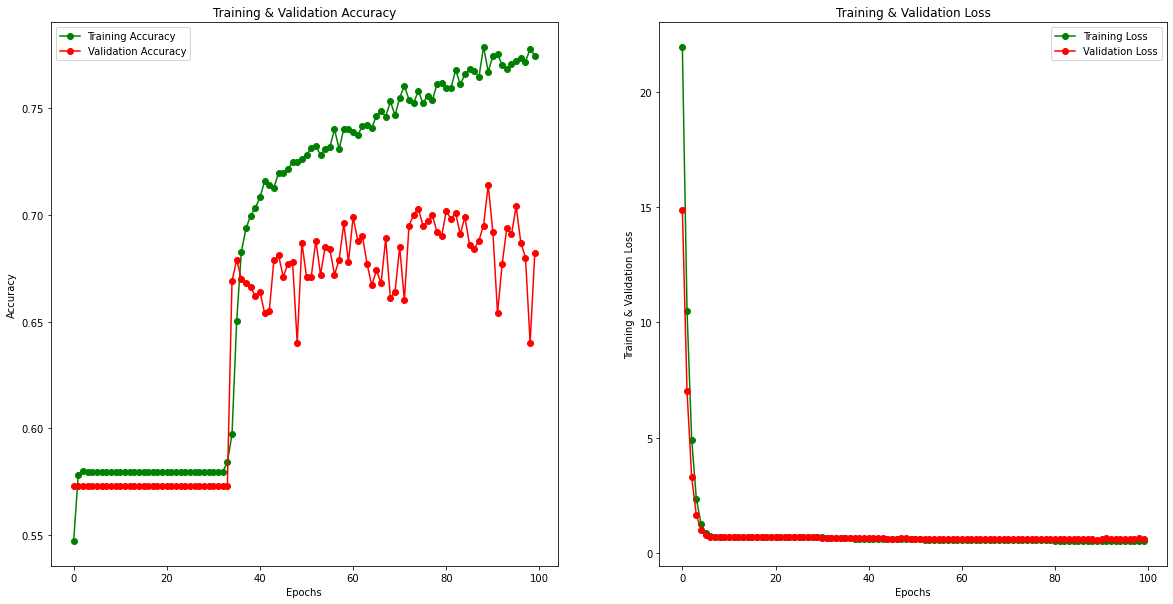

In [53]:
plot_accuracy_loss_chart(history,100)